In [1]:
!nvidia-smi

Fri Apr 12 13:33:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8               18W / 180W|   1196MiB / 12288MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
import os
from sklearn.model_selection import train_test_split

# 이미지와 라벨이 저장된 폴더 경로
image_folder_path = './datasets/eye_image_seg_xl/images_data'
mask_folder_path = './datasets/eye_image_seg_xl/labeled_data/masked_images'

# 폴더 내의 이미지 파일 목록 가져오기 (jpg와 png 파일 모두 포함)
image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) 
               if os.path.isfile(os.path.join(image_folder_path, f)) and (f.endswith('.jpg') or f.endswith('.png'))]

# 라벨 파일 목록 생성하기 (이미지 파일명에서 확장자를 제거하고 라벨 파일명 생성)
label_files = [os.path.join(mask_folder_path, f'masked_image_{os.path.splitext(os.path.basename(f))[0]}.png') for f in image_files]

# 이미지와 라벨 파일 목록을 훈련 세트와 테스트 세트로 분할 (8:2 비율)
train_images, test_images, train_labels, test_labels = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# 결과 확인
print(f"Total images: {len(image_files)}")
print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")
print(f"Training labels: {len(train_labels)}")
print(f"Testing labels: {len(test_labels)}")

Total images: 2208
Training images: 1766
Testing images: 442
Training labels: 1766
Testing labels: 442


In [26]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 이미지와 라벨이 저장된 폴더 경로
image_folder_path = './datasets/eye_image_seg_xl/images_data'
mask_folder_path = './datasets/eye_image_seg_xl/labeled_data/masked_images'

# 트레이닝과 테스팅 디렉토리 생성
train_image_dir = './datasets/eye_image_seg_xl/train/images'
train_label_dir = './datasets/eye_image_seg_xl/train/labels'
test_image_dir = './datasets/eye_image_seg_xl/test/images'
test_label_dir = './datasets/eye_image_seg_xl/test/labels'

# 필요한 경우 디렉토리 생성
for path in [train_image_dir, train_label_dir, test_image_dir, test_label_dir]:
    os.makedirs(path, exist_ok=True)

# 폴더 내의 이미지 파일 목록 가져오기 (jpg와 png 파일 모두 포함)
image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path)
               if os.path.isfile(os.path.join(image_folder_path, f)) and (f.endswith('.jpg') or f.endswith('.png'))]

# 라벨 파일 목록 생성하기, 원본 이미지 확장자에 따라 라벨 확장자 결정
label_files = [os.path.join(mask_folder_path, f'masked_image_{os.path.splitext(os.path.basename(f))[0]}.jpg' if f.endswith('.jpg') else f'masked_image_{os.path.splitext(os.path.basename(f))[0]}.png') for f in image_files]

# 이미지와 라벨 파일 목록을 훈련 세트와 테스트 세트로 분할 (8:2 비율)
train_images, test_images, train_labels, test_labels = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# 결과 확인
print(f"Total images: {len(image_files)}")
print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")
print(f"Training labels: {len(train_labels)}")
print(f"Testing labels: {len(test_labels)}")

# 트레이닝 세트 파일을 해당 디렉토리로 복사
for img, lbl in zip(train_images, train_labels):
    shutil.copy2(img, os.path.join(train_image_dir, os.path.basename(img)))
    shutil.copy2(lbl, os.path.join(train_label_dir, os.path.basename(lbl)))

# 테스트 세트 파일을 테스트 디렉토리로 복사
for img, lbl in zip(test_images, test_labels):
    shutil.copy2(img, os.path.join(test_image_dir, os.path.basename(img)))
    shutil.copy2(lbl, os.path.join(test_label_dir, os.path.basename(lbl)))

print("Files have been successfully copied to the respective directories.")


Total images: 2208
Training images: 1766
Testing images: 442
Training labels: 1766
Testing labels: 442
Files have been successfully copied to the respective directories.


In [28]:
import torch
torch.cuda.is_available()

True

In [29]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [31]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [144]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [145]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [27]:
from PIL import Image
from datasets import Dataset
import os

def create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    for image_file in os.listdir(image_folder_path):
        if image_file.endswith(".jpg") or image_file.endswith(".jpeg") or image_file.endswith(".png"):
            image_path = os.path.join(image_folder_path, image_file)
            mask_file = f"masked_image_{image_file}"
            mask_path = os.path.join(mask_folder_path, mask_file)
            
            if os.path.isfile(mask_path):
                # 이미지와 마스크를 열고 리사이징
                image = Image.open(image_path).resize(target_size)
                mask = Image.open(mask_path).resize(target_size)
                
                # 그레이스케일 이미지를 RGB로 변환
                if image.mode == 'L':
                    image = image.convert('RGB')
                
                image_paths.append(image)
                mask_paths.append(mask)
    
    dataset = Dataset.from_dict({
        'image': image_paths,
        'mask': mask_paths
    })
    
    return dataset

image_folder_path = './datasets/eye_image_seg_xl/train/images'
mask_folder_path = './datasets/eye_image_seg_xl/train/labels'

dataset = create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256))

print(dataset[0]['image'].size, dataset[0]['mask'].size)

(256, 256) (256, 256)


이미지 채널 수: RGB
이미지 채널 수: RGB


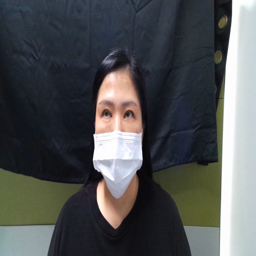

In [32]:
example = dataset[512]
image = example["image"]
image.size
channels = image.mode
print("이미지 채널 수:", channels)
image = image.convert('RGB')
channels = image.mode
print("이미지 채널 수:", channels)
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

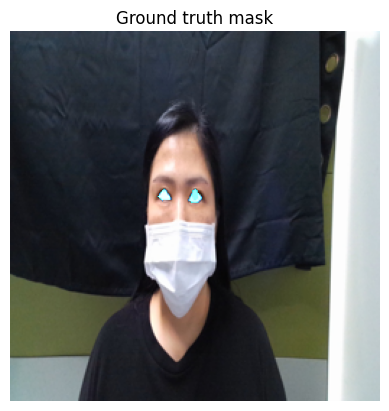

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["mask"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [34]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [35]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [36]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [38]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [39]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [40]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base", num_labels=7)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [65]:
pip install -q monai

Note: you may need to restart the kernel to use updated packages.


In [42]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [44]:
from tqdm import tqdm
import torch
import os

num_epochs = 10
best_loss = float('inf')  # 초기 최고 손실을 무한대로 설정
model_save_path = './eyball_best_model.pth'  # 모델 저장 경로

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for batch in epoch_iterator:
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_iterator.set_postfix({"loss": loss.item()})

    # Print epoch loss
    mean_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"EPOCH: {epoch+1} | Mean loss: {mean_loss}")

    # Check if the current model is the best one
    if mean_loss < best_loss:
        best_loss = mean_loss
        # Save the best model
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model saved with loss: {best_loss}")

Epoch 1/10: 100%|█████████████████████████████████████████████████████| 883/883 [09:42<00:00,  1.52batch/s, loss=-50.8]


EPOCH: 1 | Mean loss: -703.6885359413492
New best model saved with loss: -703.6885359413492


Epoch 2/10: 100%|█████████████████████████████████████████████████████| 883/883 [09:57<00:00,  1.48batch/s, loss=-93.5]


EPOCH: 2 | Mean loss: -2941.802314157799
New best model saved with loss: -2941.802314157799


Epoch 3/10: 100%|██████████████████████████████████████████████████| 883/883 [09:56<00:00,  1.48batch/s, loss=-2.43e+4]


EPOCH: 3 | Mean loss: -7581.2248358073075
New best model saved with loss: -7581.2248358073075


Epoch 4/10: 100%|██████████████████████████████████████████████████| 883/883 [09:56<00:00,  1.48batch/s, loss=-4.95e+4]


EPOCH: 4 | Mean loss: -16010.142355464188
New best model saved with loss: -16010.142355464188


Epoch 5/10: 100%|██████████████████████████████████████████████████| 883/883 [09:52<00:00,  1.49batch/s, loss=-1.18e+5]


EPOCH: 5 | Mean loss: -29348.791293929415
New best model saved with loss: -29348.791293929415


Epoch 6/10: 100%|██████████████████████████████████████████████████| 883/883 [09:28<00:00,  1.55batch/s, loss=-1.68e+5]


EPOCH: 6 | Mean loss: -49235.41082874268
New best model saved with loss: -49235.41082874268


Epoch 7/10: 100%|███████████████████████████████████████████████████| 883/883 [09:29<00:00,  1.55batch/s, loss=-4.7e+3]


EPOCH: 7 | Mean loss: -76530.85177691796
New best model saved with loss: -76530.85177691796


Epoch 8/10: 100%|██████████████████████████████████████████████████| 883/883 [09:40<00:00,  1.52batch/s, loss=-4.25e+5]


EPOCH: 8 | Mean loss: -113218.38116157851
New best model saved with loss: -113218.38116157851


Epoch 9/10: 100%|██████████████████████████████████████████████████| 883/883 [09:58<00:00,  1.48batch/s, loss=-1.15e+4]


EPOCH: 9 | Mean loss: -161005.80502426476
New best model saved with loss: -161005.80502426476


Epoch 10/10: 100%|█████████████████████████████████████████████████| 883/883 [09:49<00:00,  1.50batch/s, loss=-6.21e+5]


EPOCH: 10 | Mean loss: -221285.59903897624
New best model saved with loss: -221285.59903897624


In [53]:
from PIL import Image
from datasets import Dataset
import os

def create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    for image_file in os.listdir(image_folder_path):
        if image_file.endswith(".jpg") or image_file.endswith(".jpeg") or image_file.endswith(".png"):
            image_path = os.path.join(image_folder_path, image_file)
            mask_file = f"masked_image_{image_file}"
            mask_path = os.path.join(mask_folder_path, mask_file)
            
            if os.path.isfile(mask_path):
                # 이미지와 마스크를 열고 리사이징
                image = Image.open(image_path).resize(target_size)
                mask = Image.open(mask_path).resize(target_size)
                
                # 그레이스케일 이미지를 RGB로 변환
                if image.mode == 'L':
                    image = image.convert('RGB')
                
                image_paths.append(image)
                mask_paths.append(mask)
    
    dataset = Dataset.from_dict({
        'image': image_paths,
        'mask': mask_paths
    })
    
    return dataset

image_folder_path = './datasets/eye_image_seg_xl/test/images'
mask_folder_path = './datasets/eye_image_seg_xl/test/labels'

dataset = create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256))

print(dataset[0]['image'].size, dataset[0]['mask'].size)

(256, 256) (256, 256)


In [54]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [56]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [57]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [58]:
from transformers import SamModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

# Disable gradient computation for specific parts of the model
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Load your custom state dictionary
state_dict = torch.load('./eyball_best_model.pth', map_location=device)

# Try to load the state dictionary with error handling
try:
    # The strict=False argument allows the model to load parameters that do fit, and ignore others.
    model.load_state_dict(state_dict, strict=False)
    print("Some parameters were loaded successfully.")
except RuntimeError as e:
    print(f"Error loading state dictionary: {e}")

# Optional: Check which parameters were not loaded
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

Some parameters were loaded successfully.
Missing keys: []
Unexpected keys: []


In [ ]:
test_dataloader

In [62]:
# 모델 추론 및 IoU 계산
iou_scores = []
dice_scores = []
precision_scores = []
recall_scores = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(len(dataset)), desc="Calculating matrix", unit="images"):
        image = dataset[i]['image']
        ground_truth_mask = np.array(dataset[i]['mask'])
        
        # Prepare image + box prompt for the model
        prompt = get_bounding_box(ground_truth_mask)
        inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
        
        outputs = model(**inputs, multimask_output=False)
        
        # Apply sigmoid and convert soft mask to hard mask
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        medsam_seg = (medsam_seg_prob.cpu().numpy() > 0.5).astype(np.uint8)
        
        # Calculate IoU and update scores
        iou = calculate_iou(medsam_seg, ground_truth_mask)
        iou_scores.append(iou)

        # Dice 계산 및 점수 리스트에 추가
        dice = calculate_dice(medsam_seg, ground_truth_mask)
        dice_scores.append(dice)
        
        # Precision과 Recall 계산 및 점수 리스트에 추가
        precision, recall = calculate_precision_recall(medsam_seg, ground_truth_mask)
        precision_scores.append(precision)
        recall_scores.append(recall)

# Calculate and print average IoU
average_iou = np.mean(iou_scores)
average_dice = np.mean(dice_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print("Average IoU:", average_iou)
print("Average Dice:", average_dice)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Calculating IoU: 100%|███████████████████████████████████████████████████████████| 442/442 [02:24<00:00,  3.06images/s]

Average IoU: 0.6454008
Average Dice: 0.28443812736061713
Average Precision: 0.6626886414297574
Average Recall: 0.9564189354713134


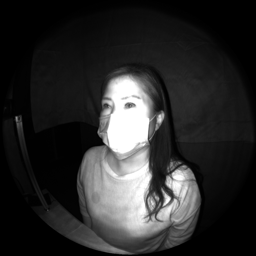

In [141]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 23

# load imageD
image = dataset[idx]["image"]
image

In [142]:
# prepare image + box prompt for the model
ground_truth_mask = np.array(dataset[idx]["mask"])
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(DEVICE)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [148]:
import time


with torch.no_grad():
    # 추론 시작 시간 기록
    start_time = time.time()
    
    # 모델 추론 수행
    outputs = model(**inputs, multimask_output=False)
    
    # 추론 종료 시간 기록
    end_time = time.time()

# 추론에 소요된 시간 계산
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

Inference time: 0.473503 seconds


In [144]:
# Apply sigmoid and convert soft mask to hard mask
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob.cpu().numpy() > 0.5).astype(np.uint8)

In [145]:
iou = calculate_iou(medsam_seg, ground_truth_mask)

In [146]:
iou

0.55263156

In [16]:
model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


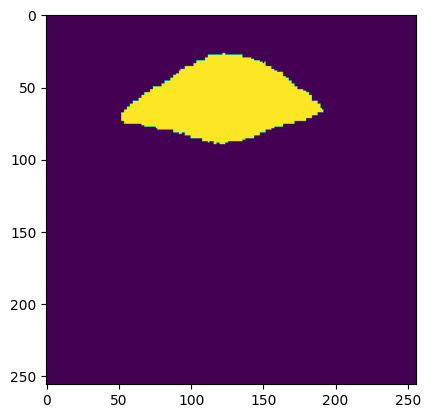

In [17]:
import matplotlib.pyplot as plt

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
print(medsam_seg)
plt.imshow(medsam_seg)

(-0.5, 255.5, 255.5, -0.5)

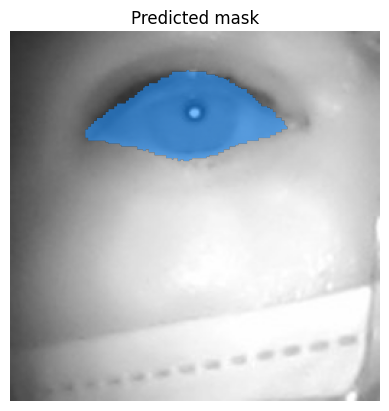

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

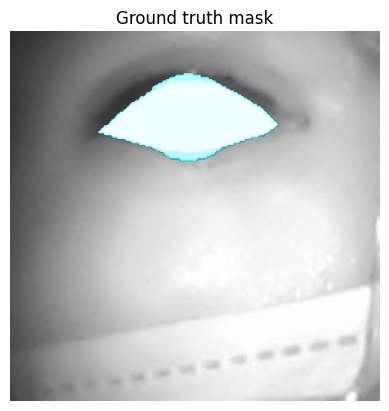

In [19]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [20]:
import numpy as np

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

def calculate_dice(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    return (2 * intersection) / (pred_mask.sum() + gt_mask.sum())

def calculate_precision_recall(pred_mask, gt_mask):
    tp = np.logical_and(pred_mask, gt_mask).sum()
    fp = np.logical_and(pred_mask, np.logical_not(gt_mask)).sum()
    fn = np.logical_and(np.logical_not(pred_mask), gt_mask).sum()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

# 예시 데이터로 함수들을 테스트해 보겠습니다.
iou = calculate_iou(medsam_seg, ground_truth_mask)
dice = calculate_dice(medsam_seg, ground_truth_mask)
precision, recall = calculate_precision_recall(medsam_seg, ground_truth_mask)

print(f"IoU: {iou:.2f}")
print(f"Dice Coefficient: {dice:.2f}")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")


IoU: 0.84
Dice Coefficient: 0.23
Precision: 0.84, Recall: 0.99


## 추론용 데이터셋 만들기

In [110]:
from PIL import Image
from datasets import Dataset
import os

def create_image_dataset(image_file, target_size=(256, 256)):
    if image_file.endswith(".jpg") or image_file.endswith(".jpeg") or image_file.endswith(".png"):
        image_path = os.path.join(image_file)
        mask_path = 'data/eye_image_seg/train/WhatsApp-Image-2023-06-07-at-21-17-050_jpg.rf.93aaa3075617070913a35954320b77ac_mask.png'

        image = Image.open(image_path).resize(target_size)
        mask = Image.open(mask_path).resize(target_size)
        
        # 이미지를 흑백으로 변환한 후 다시 RGB로 변환
        image = image.convert('L').convert('RGB')

        dataset = Dataset.from_dict({
            'image': [image],  # Storing the image as a list
            'mask': [mask]
        })

        return dataset

image_file = 'data/eye_image_seg/train/WhatsApp-Image-2023-06-07-at-21-17-050_jpg.rf.93aaa3075617070913a35954320b77ac.jpg'

dataset = create_image_dataset(image_file, target_size=(256, 256))
print(dataset[0]['image'].size)

(256, 256)


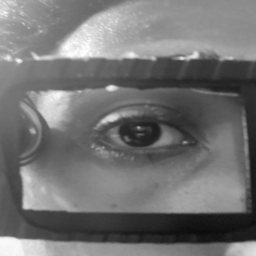

In [111]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 0

# load image
image = dataset[idx]["image"]
image

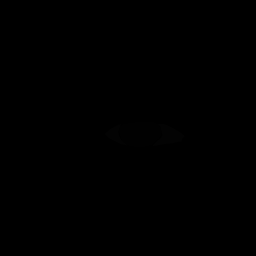

In [112]:
mask_image = dataset[idx]["mask"]
mask_image

In [113]:
# prepare image + box prompt for the model
ground_truth_mask = np.array(dataset[idx]["mask"])
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(DEVICE)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [114]:
from transformers import SamModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

# Disable gradient computation for specific parts of the model
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Load your custom state dictionary
state_dict = torch.load("eyeball_model.pth", map_location=device)

# Try to load the state dictionary with error handling
try:
    # The strict=False argument allows the model to load parameters that do fit, and ignore others.
    model.load_state_dict(state_dict, strict=False)
    print("Some parameters were loaded successfully.")
except RuntimeError as e:
    print(f"Error loading state dictionary: {e}")

# Optional: Check which parameters were not loaded
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

Some parameters were loaded successfully.
Missing keys: []
Unexpected keys: []


In [115]:
model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

In [116]:
print(outputs)

SamImageSegmentationOutput(iou_scores=tensor([[[1.1705]]], device='cuda:0'), pred_masks=tensor([[[[[-339843.6250, -327939.4688, -322277.6250,  ...,
            -351167.2812, -294569.4062, -292057.6875],
           [-384295.0000, -528660.3750, -468074.0000,  ...,
            -430369.4688, -257875.0938, -252002.1875],
           [-359822.3750, -275958.6875, -447213.1250,  ...,
            -304951.7500, -435546.1875, -331934.2188],
           ...,
           [-451268.1562, -622913.6250, -656492.5000,  ...,
            -594073.5000, -622090.4375, -641887.6875],
           [-234373.5312, -143779.1250, -225758.2500,  ...,
            -275978.1562, -398281.8750, -324822.5312],
           [-618652.5000, -654225.0625, -960054.5000,  ...,
            -522661.5000, -634833.3750, -633564.9375]]]]], device='cuda:0'), vision_hidden_states=None, vision_attentions=None, mask_decoder_attentions=None)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


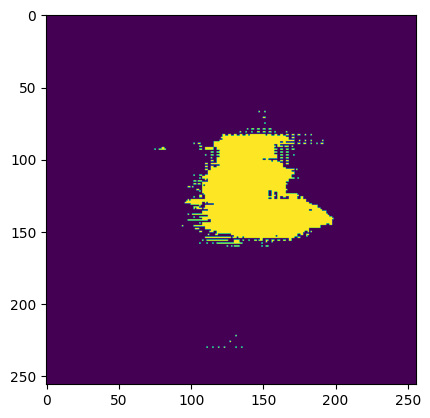

In [117]:
import matplotlib.pyplot as plt

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.7).astype(np.uint8)
print(medsam_seg)
plt.imshow(medsam_seg)

In [63]:
medsam_seg_probs = torch.softmax(outputs.pred_masks, dim=1)

In [64]:
medsam_seg_probs

tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]], device='cuda:0')

In [69]:
# Convert soft masks to hard masks by thresholding
threshold = 0.5
# Use the tensor's own greater than method to create a mask and convert to uint8
medsam_seg = (medsam_seg_probs > threshold).to(torch.uint8)

# If you need to move this to CPU and convert to a numpy array for further processing:
medsam_seg_np = medsam_seg.cpu().numpy()

In [66]:
medsam_seg_np

array([[[[[1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1],
          ...,
          [1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1]]]]], dtype=uint8)

In [ ]:
plt.imshow(medsam_seg)

In [71]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
print(medsam_seg)
plt.imshow(medsam_seg)

In [50]:
print(medsam_seg.shape)

(256, 256)


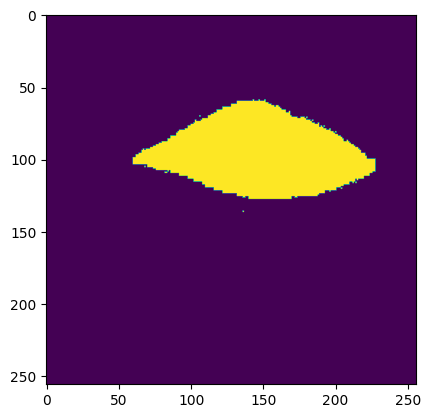

In [51]:
plt.imshow(medsam_seg)

(-0.5, 255.5, 255.5, -0.5)

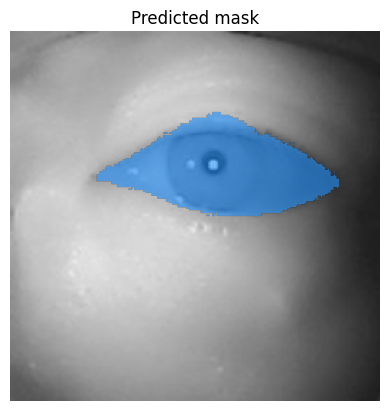

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

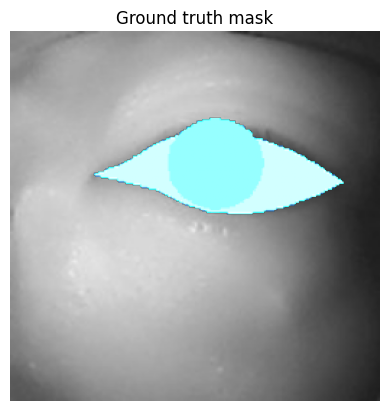

In [48]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [ ]:
import numpy as np

def calculate_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

def calculate_dice(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    return (2 * intersection) / (pred_mask.sum() + gt_mask.sum())

def calculate_precision_recall(pred_mask, gt_mask):
    tp = np.logical_and(pred_mask, gt_mask).sum()
    fp = np.logical_and(pred_mask, np.logical_not(gt_mask)).sum()
    fn = np.logical_and(np.logical_not(pred_mask), gt_mask).sum()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

# 예시 데이터로 함수들을 테스트해 보겠습니다.
iou = calculate_iou(medsam_seg, ground_truth_mask)
dice = calculate_dice(medsam_seg, ground_truth_mask)
precision, recall = calculate_precision_recall(medsam_seg, ground_truth_mask)

print(f"IoU: {iou:.2f}")
print(f"Dice Coefficient: {dice:.2f}")
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

In [34]:
# 이진 배열
binary_array = [
    "0000000000000000",
    "0000001000000000",
    "0010111111000000",
    "0000000000111110",
    "0000000000000000",
    "0000000000000100"
]

# 좌표 값을 찾기 위한 초기 설정
y_max = None
x_min = len(binary_array[0])
x_max = -1
y_min = None

# 각 행을 순회하면서 y_max, y_min, x_min, x_max 값을 구함
for i, row in enumerate(binary_array):
    if '1' in row:
        if y_max is None:
            y_max = i
        y_min = i
        current_x_min = row.index('1')
        current_x_max = row.rindex('1')
        if current_x_min < x_min:
            x_min = current_x_min
        if current_x_max > x_max:
            x_max = current_x_max

# 결과 출력
print("y_max:", y_max)
print("x_min:", x_min)
print("x_max:", x_max)
print("y_min:", y_min)

y_max: 1
x_min: 2
x_max: 14
y_min: 5


In [56]:
import numpy as np

# 각 요소가 정수로 이루어진 NumPy 배열
binary_array = medsam_seg

# 좌표 값을 찾기 위한 초기 설정
y_max = None
x_min = binary_array.shape[1]  # 너비
x_max = -1
y_min = None

# 각 행을 순회하면서 y_max, y_min, x_min, x_max 값을 구함
for i, row in enumerate(binary_array):
    if 1 in row:
        if y_max is None:
            y_max = i
        y_min = i
        indices = np.where(row == 1)[0]  # 1의 인덱스 찾기
        current_x_min = indices.min()  # 최소 인덱스
        current_x_max = indices.max()  # 최대 인덱스
        if current_x_min < x_min:
            x_min = current_x_min
        if current_x_max > x_max:
            x_max = current_x_max

# 결과 출력
print("x_min:", x_min)
print("x_max:", x_max)

y_max: 59
x_min: 60
x_max: 227
y_min: 136


In [41]:
!pip install patchify

  Using cached patchify-0.2.3-py3-none-any.whl.metadata (3.0 kB)
Using cached patchify-0.2.3-py3-none-any.whl (6.6 kB)


In [70]:
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]


input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [71]:
print(np.array(input_points).shape)

(1, 1, 100, 2)


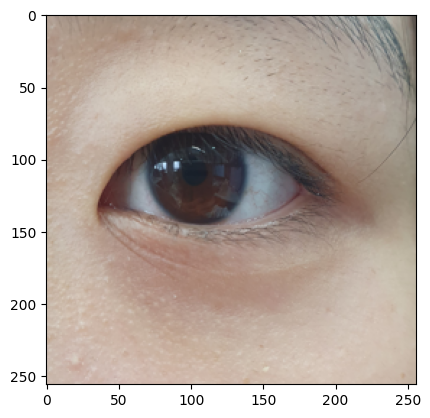

In [72]:
from PIL import Image
import requests

raw_image = Image.open('./hyemin_eye.jpg').resize([256, 256])

plt.imshow(raw_image)

In [73]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [74]:
# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


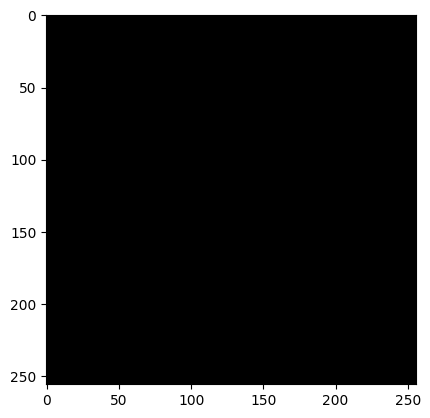

In [75]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
print(medsam_seg)
plt.imshow(medsam_seg, cmap='gray')

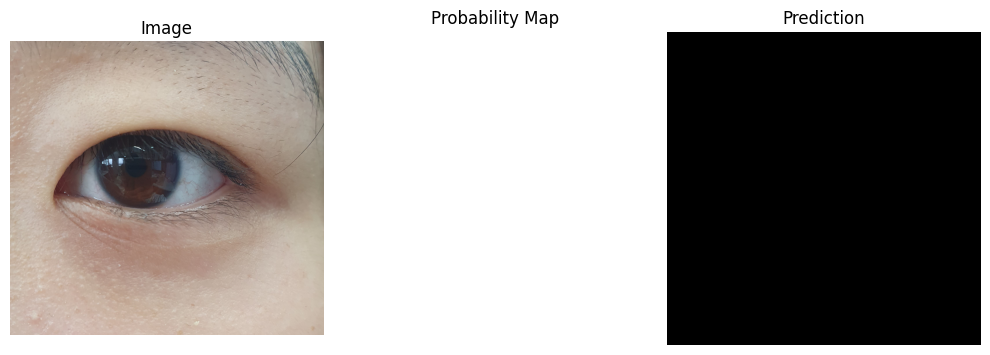

In [77]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

# Reshape input_points to the expected shape
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

# Load the image
image_path = "./hyemin_eye.jpg"  # Replace "your_image_path.jpg" with the path to your image
single_patch = Image.open(image_path)

# Prepare image for the model
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

# Apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# Convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

# Plot the results
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(single_patch, cmap='gray')
plt.title("Image")
plt.axis('off')

# Plot the probability map
plt.subplot(1, 3, 2)
plt.imshow(single_patch_prob, cmap='hot', vmin=0, vmax=1)
plt.title("Probability Map")
plt.axis('off')

# Plot the prediction
plt.subplot(1, 3, 3)
plt.imshow(single_patch_prediction, cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()